In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import HTML

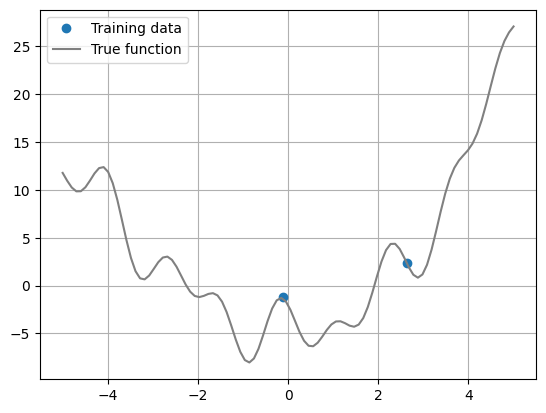

In [2]:
@tf.function
def unknown_function(X):
    return -2* tf.sin(5*X - 0.5) + 2 * tf.cos(3*X) - 5 + tf.square(X) - 0.05 * (tf.exp(-X) - tf.exp(X))

noise = 0.1
n_train = 2
lim = 5
X_train = tf.random.uniform([n_train], -lim, lim) 
Y_train = unknown_function(X_train) + np.random.normal(0, noise, n_train)

plt.plot( X_train, Y_train, 'o', label='Training data')
plt.plot(tf.linspace(-lim, lim, 100), unknown_function(tf.linspace(-lim, lim, 100)),color='grey',label='True function')
plt.legend()
plt.grid()
plt.show()

In [3]:
@tf.function(reduce_retracing=True)
def radial_basis_kernel(X1, X2, variance, lengthscale):
    pairwise_diffs = tf.expand_dims(X1, 1) - tf.expand_dims(X2, 0)
    squared_diffs  = tf.square(pairwise_diffs / lengthscale)
    kernel_matrix = tf.multiply(variance, tf.exp(-squared_diffs))
    return kernel_matrix

In [4]:
def calculate_kernel_matrices(X_train, Y_train):
    n_train = len(X_train)
    lengthscale = tf.Variable(1.0)
    variance = tf.Variable(1.0)
    RBF_prior = radial_basis_kernel(X_train, X_train, variance, lengthscale) + tf.eye(n_train) * 1e-5

    # Specifying parameters of testing 
    n_test = 100
    X_test = tf.sort(tf.random.uniform([n_test], -lim, lim))

    # Calculate the kernel matrix for the posterior distribution
    K_s = radial_basis_kernel(X_test, X_train, variance, lengthscale)
    K_ss = radial_basis_kernel(X_test, X_test, variance, lengthscale) + tf.eye(n_test) * 1e-4

    # Cholesky decomposition of the prior kernel matrix
    L = tf.linalg.cholesky(RBF_prior)
    alpha = tf.linalg.cholesky_solve(L, tf.expand_dims(Y_train, -1))
    mu_s = tf.matmul(K_s, alpha)
    v = tf.linalg.cholesky_solve(L, tf.transpose(K_s))
    cov_s = K_ss - tf.matmul(K_s, v)

    return X_test, K_s, K_ss, L, alpha, mu_s, v, cov_s

# Example usage:
X_test, K_s, K_ss, L, alpha, mu_s, v, cov_s = calculate_kernel_matrices(X_train, Y_train)


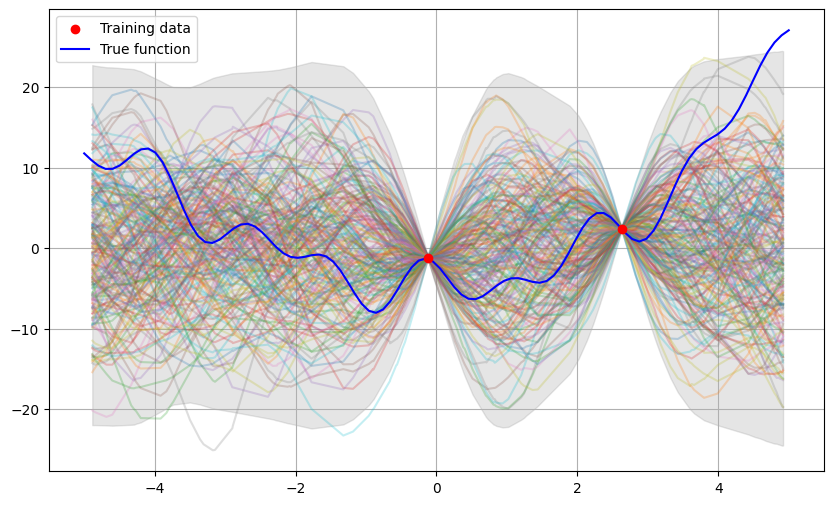

In [5]:
# Create the multivariate normal distribution
mv_normal = tfp.distributions.MultivariateNormalTriL(
    loc=tf.reshape(mu_s, [-1]),
    scale_tril=tf.linalg.cholesky(cov_s)*7.5
)

# Sample from the distribution
samples = mv_normal.sample(200)

# Calculate mean and confidence intervals
mean_prediction = tf.reduce_mean(samples, axis=0)
std_prediction = tf.math.reduce_std(samples, axis=0)

# Plot the mean prediction and confidence intervals
plt.figure(figsize=(10, 6))
#plt.scatter(X_test, mean_prediction,marker='o', label='Mean prediction')
for i in samples:
    plt.plot(X_test,i,alpha = 0.25,linestyle='-')
plt.fill_between(X_test, 
                 (mean_prediction - 3 * std_prediction).numpy(), 
                 (mean_prediction + 3 * std_prediction).numpy(), \
                 color='gray', alpha=0.2)
plt.scatter(X_train, Y_train, color='red', label='Training data',zorder=10000)
plt.plot(tf.linspace(-lim, lim, 100), unknown_function(tf.linspace(-lim, lim, 100)),color='blue',label='True function')
plt.legend()
plt.grid()
plt.show()



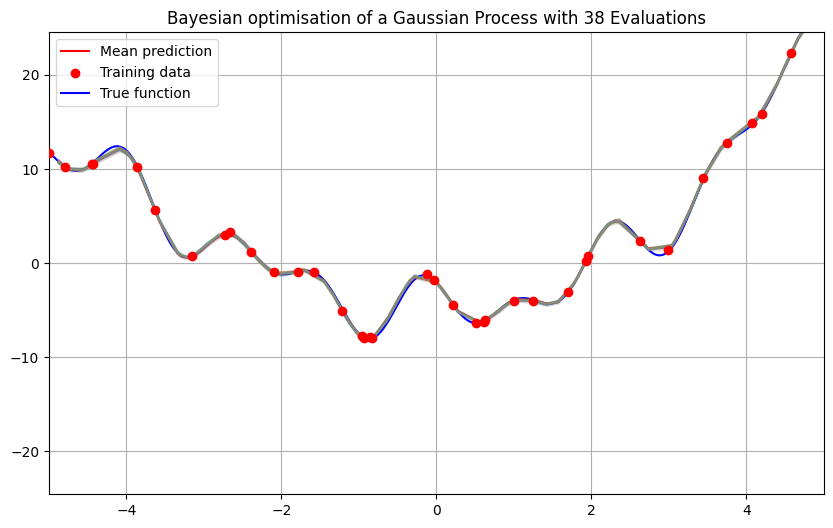

In [6]:
import matplotlib.animation as animation

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'r-', label='Mean prediction')
scatter = ax.scatter([], [], color='red', label='Training data', zorder=10000)
fill_between = ax.fill_between([], [], [], color='gray', alpha=0.2)
mini_lines = []
true_function_line, = ax.plot(tf.linspace(-lim, lim, 1000), unknown_function(tf.linspace(-lim, lim, 1000)), color='blue', label='True function')
old_opt = 10000
ax.legend()
ax.grid()

# Set plot limits
ax.set_xlim(-lim, lim)
ax.set_ylim((np.min((mean_prediction - 3 * std_prediction).numpy()),np.max((mean_prediction + 3 * std_prediction).numpy())))

def init():
    line.set_data([], [])
    scatter.set_offsets(np.empty((0, 2)))
    global fill_between, mini_lines
    for mini_line in mini_lines:
        mini_line.remove()
    mini_lines = []
    if fill_between:
        fill_between.remove()
        fill_between = None
    return line, scatter

def update(frame):
    global X_train, Y_train, mean_prediction, std_prediction, fill_between, X_test, old_opt,mini_lines
    arg_min = np.argmin((mean_prediction - 3 * std_prediction).numpy())
    new_opt = unknown_function(X_test[arg_min].numpy())
    if np.abs(new_opt - old_opt) < 10e-1:
        arg_min = np.argmax(std_prediction)
        new_opt = unknown_function(X_test[arg_min].numpy())
    else:
        old_opt = new_opt
    X_train = tf.concat([X_train, [X_test[arg_min].numpy()]], axis=0)
    Y_train = tf.concat([Y_train, [new_opt + np.random.normal(0, noise)]], axis=0)

    X_test, K_s, K_ss, L, alpha, mu_s, v, cov_s = calculate_kernel_matrices(X_train, Y_train)
    mv_normal = tfp.distributions.MultivariateNormalTriL(loc=tf.reshape(mu_s, [-1]), scale_tril=tf.linalg.cholesky(cov_s) * 7.5)
    samples = mv_normal.sample(20)
    mean_prediction = tf.reduce_mean(samples, axis=0)
    std_prediction = tf.math.reduce_std(samples, axis=0)

    line.set_data(X_test.numpy(), mean_prediction.numpy())
    scatter.set_offsets(np.c_[X_train.numpy(), Y_train.numpy()])

    if fill_between:
        fill_between.remove()
    fill_between = ax.fill_between(X_test.numpy().flatten(), 
                                   (mean_prediction - 3 * std_prediction).numpy().flatten(), 
                                   (mean_prediction + 3 * std_prediction).numpy().flatten(), 
                                   color='gray', alpha=0.2)
    
    for mini_line in mini_lines:
        mini_line.remove()
    mini_lines = ax.plot(X_test.numpy(), samples.numpy().T, alpha=0.25, linestyle='-')
    plt.title(f'Bayesian optimisation of a Gaussian Process with {len(X_train)} Evaluations')
    return line, scatter, fill_between, *mini_lines

ani = animation.FuncAnimation(fig, update, frames=18, init_func=init, blit=True, repeat=False)
ani.save('animation.gif', writer='pillow')
HTML(ani.to_jshtml())


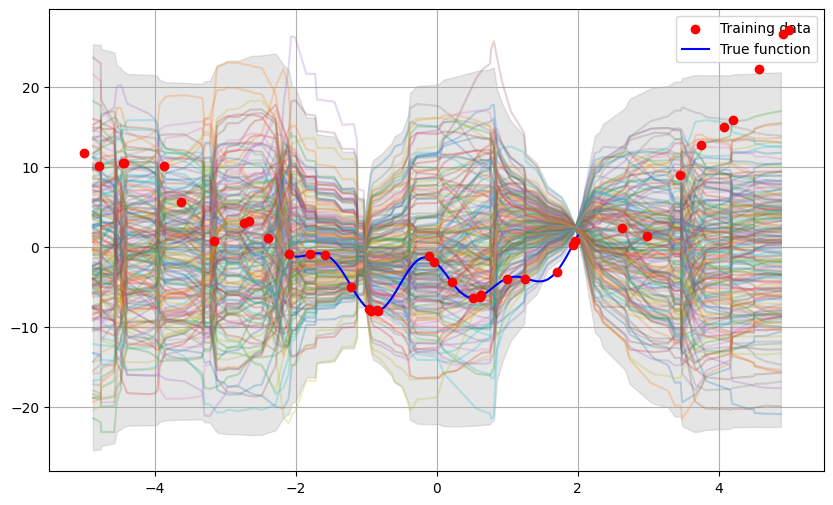

In [7]:
# Create the multivariate normal distribution
mv_normal = tfp.distributions.MultivariateNormalTriL(
    loc=tf.reshape(mu_s, [-1]),
    scale_tril=tf.linalg.cholesky(cov_s)*7.5
)

# Sample from the distribution
samples = mv_normal.sample(200)

# Calculate mean and confidence intervals
mean_prediction = tf.reduce_mean(samples, axis=0)
std_prediction = tf.math.reduce_std(samples, axis=0)

# Plot the mean prediction and confidence intervals
plt.figure(figsize=(10, 6))
#plt.scatter(X_test, mean_prediction,marker='o', label='Mean prediction')
for i in samples:
    plt.plot(X_test,i,alpha = 0.25,linestyle='-')
plt.fill_between(X_test, 
                 (mean_prediction - 3 * std_prediction).numpy(), 
                 (mean_prediction + 3 * std_prediction).numpy(), \
                 color='gray', alpha=0.2)
plt.scatter(X_train, Y_train, color='red', label='Training data',zorder=10000)
plt.plot(tf.linspace(-2, 2, 100), unknown_function(tf.linspace(-2, 2, 100)),color='blue',label='True function')
plt.legend()
plt.grid()
plt.show()

